# Data Quality Check 1 - Name Update (Within Database)

## Overview
This process ensures data consistency by verifying and updating name matches between two datasets: the **ForayNL DB** and **Mycobank**. 

---

## Data Sources
1. **Foray NL 2023 Database**:  
   - **Source**: Foray NL 2023 database.  
   - **Details**: Extracted from the "All Species" dataset, specifically the `Species` column.  
   
2. **Mycobank Total List of Mushroom Species**:  
   - **Source**: [Mycobank](https://www.mycobank.org/).  
   - **Details**: Updated list of mushroom species as of **January 15, 2025**.

---


In [ ]:
# essential libraries (Uncomment the line below to install it:)

# !pip install rapidfuzz

## 1. Step One - matching with mycobank database:

1. **Load Data and Library**: Used [rapidfuzz](https://github.com/rapidfuzz/RapidFuzz)
2. **Grouping**: Group Mycobank names by first letter for searching efficiency.
3. **Matching**: Use `fuzz.ratio` with a 90% similarity threshold.
4. **Parallel Processing**: Match names using `ThreadPoolExecutor`.
5. **Save Results**

In [8]:
import pandas as pd
from rapidfuzz import process, fuzz
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from collections import defaultdict

try:
    db = pd.read_csv("Foray2023_DB/FORAY2023_DB_All species2023.csv")
    Myco_db = pd.read_csv("MBList.csv")

    if "Species" not in db.columns or "Taxon name" not in Myco_db.columns:
        raise KeyError("Required columns 'Species' or 'Taxon name' are missing in the input files.")

    db_name = db["Species"].tolist()
    Myco_db_name = Myco_db["Taxon name"].tolist()
    
    # similarity threshold
    threshold = 90

    # Group target names in Myco by first letter
    grouped_myco_db = defaultdict(list)
    for name in Myco_db_name:
        first_letter = name[0].lower()
        grouped_myco_db[first_letter].append(name)
    
    # Matching within optimized grouping
    def find_best_match(name):
        first_letter = name[0].lower() 
        target_group = grouped_myco_db.get(first_letter, Myco_db_name)  # Fallback to full list if no group found
        match = process.extractOne(name, target_group, scorer=fuzz.ratio, score_cutoff=threshold)
        return {
            "ForayNL Name": name,
            "Mycobank Name": match[0] if match else "", 
        }

    # Use ThreadPoolExecutor for parallel processing
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(find_best_match, db_name), total=len(db_name), desc="Processing"))
    
    # Save result
    results_df = pd.DataFrame(results)
    results_df.to_csv("Name_check_2023_optimized.csv", index=False)

except Exception as e:
    print(f"Error: {e}")

Processing: 100%|██████████| 2104/2104 [00:03<00:00, 663.05it/s]


## 2. Step Two - matching with mycobank database:

1. **Load Data**: From newly matched result
2. **Matching Logic**:
   - Exact match: `0`
   - Spacing issues: `1`
   - Similar but not exact: `2`
   - Missing or unmatched: `3`
3. **Save Results**: Output to `Name_check_2023_with_values_v2.csv`.

In [9]:
import pandas as pd
from rapidfuzz import process, fuzz
from tqdm import tqdm

try:
    input_data = pd.read_csv("Name_check_2023_optimized.csv")
    if "ForayNL Name" not in input_data.columns or "Mycobank Name" not in input_data.columns:
        raise KeyError("Required columns 'ForayNL Name' or 'Mycobank Name' are missing in the input file.")

    foray_names = input_data["ForayNL Name"].tolist()
    myco_names = input_data["Mycobank Name"].tolist()

    threshold = 90

    # store results
    results = []

    def normalize_name(name):
        """Normalize a name by stripping and reducing spaces."""
        return " ".join(name.split()) if pd.notna(name) else name

    for foray_name, myco_name in tqdm(zip(foray_names, myco_names), desc="Processing", total=len(foray_names)):

        foray_normalized = normalize_name(foray_name)
        myco_normalized = normalize_name(myco_name)

        if pd.isna(foray_name) or pd.isna(myco_name):  # missing values - 3
            value = 3
        elif foray_name == myco_name:  # Exact match - 0
            value = 0
        elif foray_normalized == myco_normalized:  # Match ignoring extra spaces - 1
            value = 1
        else:  # Check for partial match - 2
            similarity = fuzz.ratio(foray_normalized, myco_normalized)
            value = 2 if similarity >= threshold else 3

        results.append({
            "ForayNL Name": foray_name,
            "Mycobank Name": myco_name,
            "Value": value,
        })

    results_df = pd.DataFrame(results)
    results_df.to_csv("Name_check_2023_with_values_v2.csv", index=False)

except Exception as e:
    print(f"Error: {e}")

Processing: 100%|██████████| 2104/2104 [00:00<00:00, 196508.76it/s]


visualize the result

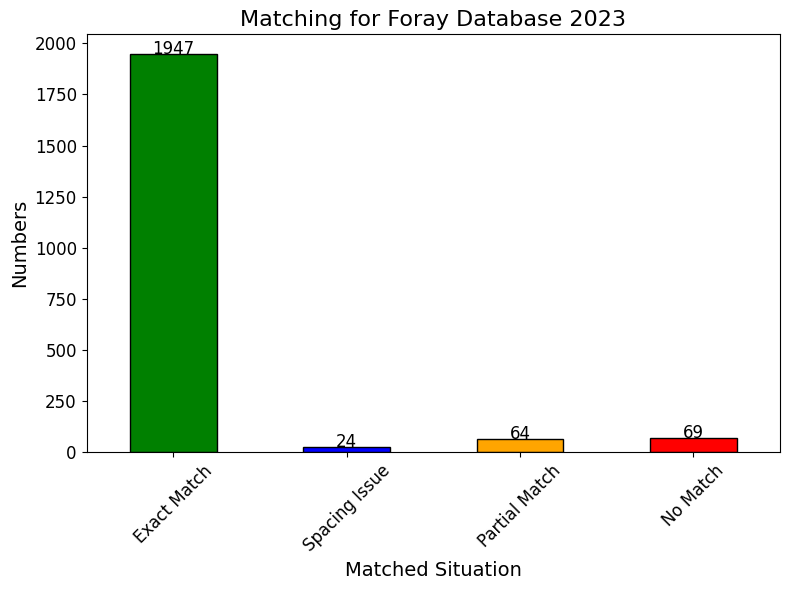

In [10]:
import matplotlib.pyplot as plt

# Load the processed data
data = pd.read_csv("Name_check_2023_with_values_v2.csv")

# Count the occurrences of each match category
match_counts = data["Value"].value_counts().sort_index()

# Define category labels
category_labels = {0: "Exact Match", 1: "Spacing Issue", 2: "Partial Match", 3: "No Match"}
match_counts.index = match_counts.index.map(category_labels)

# Create a bar chart
plt.figure(figsize=(8, 6))
match_counts.plot(kind='bar', color=['green', 'blue', 'orange', 'red'], edgecolor='black')

# Customize the chart
plt.title("Matching for Foray Database 2023", fontsize=16)
plt.xlabel("Matched Situation", fontsize=14)
plt.ylabel("Numbers", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

for i, count in enumerate(match_counts):
    plt.text(i, count + 1, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

future work: try to further automate the process using database and website API instead of matching with files.